# ÌÜµÍ≥ÑÎüâ Î∞è Î∂ÑÌè¨

In [11]:
import json
file_path = "/home/work/factchecking/PetQA/data/interim/unique_data.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

selected_cnt = 0
for item in data:
    answers = item["answers"]
    for a in answers:
        if a["selected"]:
            selected_cnt += 1
print(selected_cnt)

64129


In [1]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken
import math
import re
import sys
from collections import Counter

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

In [12]:
import json
raw_data_path = "/home/work/factchecking/PetQA/data/interim/cleaned_data.json"
with open(raw_data_path, 'r', encoding='utf-8') as f:
	data = json.load(f)
print(data[0].keys())
print(len(data))

dict_keys(['q_id', 'title', 'content', 'answer', 'a_id', 'answer_type', 'question_date', 'answer_date', 'animal_type', 'preprocessed_question', 'preprocessed_answer'])
55393


55393


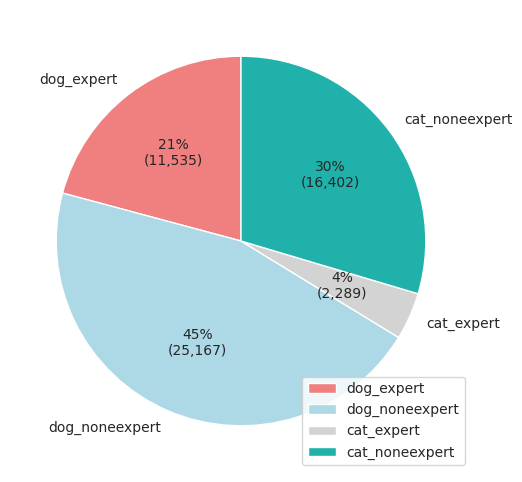

In [24]:
dog_expert = []
dog_noneexpert = []
cat_expert = []
cat_noneexpert = []

for item in data:
    if item['animal_type'] == 'dog':
        if item['answer_type'] == 'expert':
            dog_expert.append(item)
        else:
            dog_noneexpert.append(item)
    else:
        if item['answer_type'] == 'expert':
            cat_expert.append(item)
        else:
            cat_noneexpert.append(item)

labels = ['dog_expert', 'dog_noneexpert', 'cat_expert', 'cat_noneexpert']
sizes = [len(dog_expert), len(dog_noneexpert), len(cat_expert), len(cat_noneexpert)]
colors = ['lightcoral', 'lightblue', 'lightgray', 'lightseagreen']
total_size = sum(sizes)
print(total_size)

def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return "{:.0f}%\n({:,d})".format(pct, absolute)

plt.pie(
    sizes,
    labels=labels,
    startangle=90,
    autopct=lambda pct: func(pct, sizes),
    colors=colors,
)
plt.legend(labels)
plt.show()

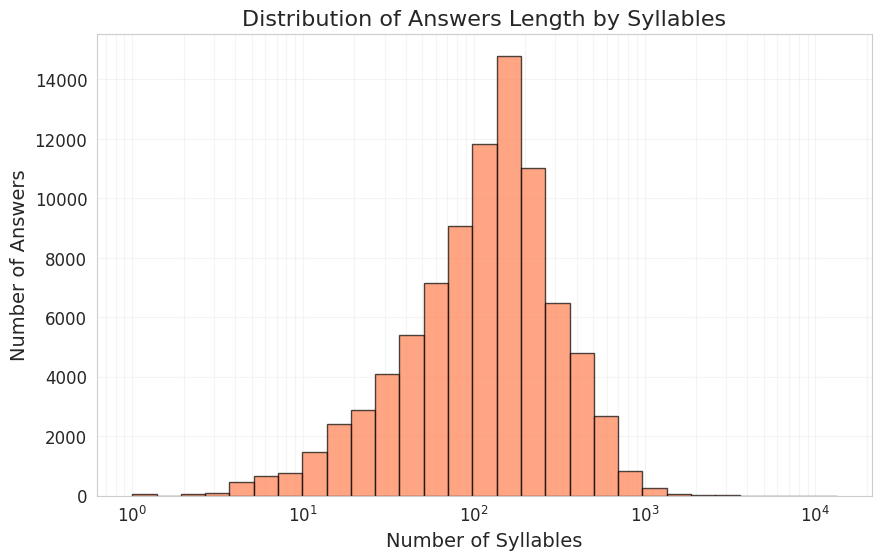

min_syllable: 0
max_syllable: 11128


In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np


def count_korean_syllables(text):
	return sum(1 for char in text if 'Í∞Ä' <= char <= 'Ìû£')

syllable_counts = {}
for item in data:
	# title = item.get('title')
	# content = item.get('content', '')
	# question = f"{title}\n{content}".strip()
	# if question:
	#     syllable_cnt = count_korean_syllables(question)
	#     syllable_counts[syllable_cnt] = syllable_counts.get(syllable_cnt, 0) + 1
	answers = item.get('answers', [])
	for answer in answers:
		answer_text = answer.get('answer', '')
		if answer_text:
			syllable_cnt = count_korean_syllables(answer_text)
			syllable_counts[syllable_cnt] = syllable_counts.get(syllable_cnt, 0) + 1

syllables = list(syllable_counts.keys())
counts = list(syllable_counts.values())

# Î°úÍ∑∏ Ïä§ÏºÄÏùº Îπà ÏÉùÏÑ±
min_syllable = min(syllables) if syllables else 1
max_syllable = max(syllables) if syllables else 10000

bins = np.logspace(np.log10(max(1, min_syllable * 0.8)), np.log10(max_syllable * 1.2), num=30)

plt.figure(figsize=(10, 6))
plt.hist(syllables, bins=bins, weights=counts, color='coral', edgecolor='black', alpha=0.7)
plt.xscale('log') # xÏ∂ïÏùÑ Î°úÍ∑∏ Ïä§ÏºÄÏùºÎ°ú ÏÑ§Ï†ï
plt.xlabel('Number of Syllables', fontsize=14)
plt.ylabel('Number of Answers', fontsize=14)
plt.title('Distribution of Answers Length by Syllables', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print(f"min_syllable: {min_syllable}")
print(f"max_syllable: {max_syllable}")


In [8]:
model = 'gpt-4o-mini'
encoding = tiktoken.encoding_for_model(model) 

def count_sentences(text):
	if not text or not isinstance(text, str):
		return 0
	# Î¨∏Ïû• Íµ¨Î∂ÑÏûê: ÎßàÏπ®Ìëú, ÎäêÎÇåÌëú, Î¨ºÏùåÌëú, Ï§ÑÎ∞îÍøà
	sentences = re.split(r'[.!?]+|\n+', text.strip())
	# Îπà Î¨∏Ïû• Ï†úÍ±∞
	sentences = [s.strip() for s in sentences if s.strip()]
	return len(sentences)

def count_tokens(text):
	if not text or not isinstance(text, str):
		return 0
	return len(encoding.encode(text))

questions = []
token_counts = []
sentence_counts = []

for item in data:
	title = item.get('title', '')
	content = item.get('content', '')
	
	# titleÍ≥º contentÎ•º Í≥µÎ∞±ÏúºÎ°ú Ïó∞Í≤∞ÌïòÏó¨ ÏßàÎ¨∏ ÏÉùÏÑ±
	question = f"{title}\n{content}".strip()
	
	# ÌÜ†ÌÅ∞ ÏàòÏôÄ Î¨∏Ïû• Ïàò Í≥ÑÏÇ∞
	token_count = count_tokens(question)
	sentence_count = count_sentences(question)
	
	questions.append(question)
	token_counts.append(token_count)
	sentence_counts.append(sentence_count)

avg_tokens = np.mean(token_counts)
avg_sentences = np.mean(sentence_counts)
median_tokens = np.median(token_counts)
median_sentences = np.median(sentence_counts)
std_tokens = np.std(token_counts)
std_sentences = np.std(sentence_counts)

print(f"=== Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÏÑù Í≤∞Í≥º ===")
print(f"Ï¥ù Îç∞Ïù¥ÌÑ∞ Ïàò: {len(data)}")
print(f"\n=== ÌÜ†ÌÅ∞ Ïàò ÌÜµÍ≥Ñ ===")
print(f"ÌèâÍ∑† ÌÜ†ÌÅ∞ Ïàò: {avg_tokens:.2f}")
print(f"Ï§ëÍ∞ÑÍ∞í ÌÜ†ÌÅ∞ Ïàò: {median_tokens:.2f}")
print(f"ÌëúÏ§ÄÌé∏Ï∞® ÌÜ†ÌÅ∞ Ïàò: {std_tokens:.2f}")
print(f"ÏµúÏÜå ÌÜ†ÌÅ∞ Ïàò: {min(token_counts)}")
print(f"ÏµúÎåÄ ÌÜ†ÌÅ∞ Ïàò: {max(token_counts)}")

print(f"\n=== Î¨∏Ïû• Ïàò ÌÜµÍ≥Ñ ===")
print(f"ÌèâÍ∑† Î¨∏Ïû• Ïàò: {avg_sentences:.2f}")
print(f"Ï§ëÍ∞ÑÍ∞í Î¨∏Ïû• Ïàò: {median_sentences:.2f}")
print(f"ÌëúÏ§ÄÌé∏Ï∞® Î¨∏Ïû• Ïàò: {std_sentences:.2f}")
print(f"ÏµúÏÜå Î¨∏Ïû• Ïàò: {min(sentence_counts)}")
print(f"ÏµúÎåÄ Î¨∏Ïû• Ïàò: {max(sentence_counts)}")

=== Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÏÑù Í≤∞Í≥º ===
Ï¥ù Îç∞Ïù¥ÌÑ∞ Ïàò: 62025

=== ÌÜ†ÌÅ∞ Ïàò ÌÜµÍ≥Ñ ===
ÌèâÍ∑† ÌÜ†ÌÅ∞ Ïàò: 141.22
Ï§ëÍ∞ÑÍ∞í ÌÜ†ÌÅ∞ Ïàò: 109.00
ÌëúÏ§ÄÌé∏Ï∞® ÌÜ†ÌÅ∞ Ïàò: 119.68
ÏµúÏÜå ÌÜ†ÌÅ∞ Ïàò: 5
ÏµúÎåÄ ÌÜ†ÌÅ∞ Ïàò: 3422

=== Î¨∏Ïû• Ïàò ÌÜµÍ≥Ñ ===
ÌèâÍ∑† Î¨∏Ïû• Ïàò: 4.87
Ï§ëÍ∞ÑÍ∞í Î¨∏Ïû• Ïàò: 4.00
ÌëúÏ§ÄÌé∏Ï∞® Î¨∏Ïû• Ïàò: 4.01
ÏµúÏÜå Î¨∏Ïû• Ïàò: 1
ÏµúÎåÄ Î¨∏Ïû• Ïàò: 94


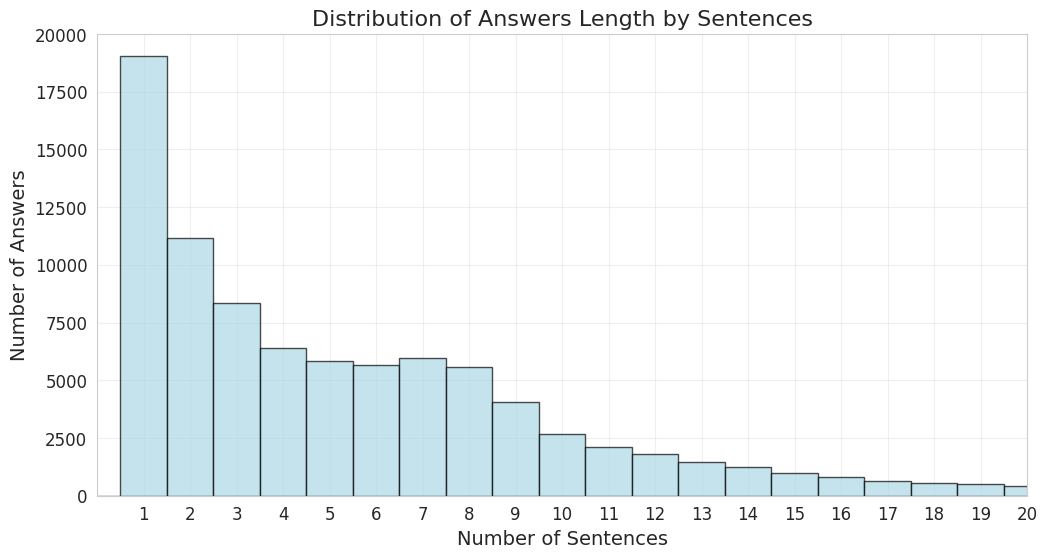

min_sentence: 0
max_sentence: 262

=== Î¨∏Ïû• Ïàò ÌÜµÍ≥Ñ ===
Ï¥ù ÎãµÎ≥Ä Ïàò: 87431
ÌèâÍ∑† Î¨∏Ïû• Ïàò: 5.86
Ï§ëÍ∞ÑÍ∞í Î¨∏Ïû• Ïàò: 41.00
ÏµúÏÜå Î¨∏Ïû• Ïàò: 0
ÏµúÎåÄ Î¨∏Ïû• Ïàò: 262

=== ÏÉÅÏúÑ 10Í∞ú Î¨∏Ïû• Ïàò ÎπàÎèÑ ===
1Î¨∏Ïû•: 19056Í∞ú ÎãµÎ≥Ä
2Î¨∏Ïû•: 11183Í∞ú ÎãµÎ≥Ä
3Î¨∏Ïû•: 8347Í∞ú ÎãµÎ≥Ä
4Î¨∏Ïû•: 6380Í∞ú ÎãµÎ≥Ä
7Î¨∏Ïû•: 5966Í∞ú ÎãµÎ≥Ä
5Î¨∏Ïû•: 5855Í∞ú ÎãµÎ≥Ä
6Î¨∏Ïû•: 5682Í∞ú ÎãµÎ≥Ä
8Î¨∏Ïû•: 5554Í∞ú ÎãµÎ≥Ä
9Î¨∏Ïû•: 4067Í∞ú ÎãµÎ≥Ä
10Î¨∏Ïû•: 2692Í∞ú ÎãµÎ≥Ä


In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re

raw_data_path = "/home/work/factchecking/PetQA/data/interim/petqa.json"

with open(raw_data_path, 'r', encoding='utf-8') as f:
	data = json.load(f)

def count_sentences(text):
	if not text or not isinstance(text, str):
		return 0
	# Î¨∏Ïû• Íµ¨Î∂ÑÏûê: ÎßàÏπ®Ìëú, ÎäêÎÇåÌëú, Î¨ºÏùåÌëú, Ï§ÑÎ∞îÍøà
	sentences = re.split(r'[.!?]+|\n+', text.strip())
	# Îπà Î¨∏Ïû• Ï†úÍ±∞
	sentences = [s.strip() for s in sentences if s.strip()]
	return len(sentences)

sentence_counts = {}
for item in data:
	answers = item.get('answers', [])
	for answer in answers:
		answer_text = answer.get('answer', '')
		if answer_text:
			sentence_cnt = count_sentences(answer_text)
			sentence_counts[sentence_cnt] = sentence_counts.get(sentence_cnt, 0) + 1

sentences = list(sentence_counts.keys())
counts = list(sentence_counts.values())

# Ï†ïÏàò Îπà ÏÉùÏÑ± (1Î∂ÄÌÑ∞ ÏµúÎåÄ Î¨∏Ïû• ÏàòÍπåÏßÄ)
min_sentence = min(sentences) if sentences else 1
max_sentence = max(sentences) if sentences else 100

# Ï†ïÏàò Îπà ÏÉùÏÑ±
bins = np.arange(min_sentence - 0.5, max_sentence + 1.5, 1)

plt.figure(figsize=(12, 6))
plt.hist(sentences, bins=bins, weights=counts, color='lightblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Sentences', fontsize=14)
plt.ylabel('Number of Answers', fontsize=14)
plt.title('Distribution of Answers Length by Sentences', fontsize=16)
plt.xticks(range(1, 21), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 20)  # xÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï
plt.show()


print(f"min_sentence: {min_sentence}")
print(f"max_sentence: {max_sentence}")

# Ï∂îÍ∞Ä ÌÜµÍ≥Ñ Ï†ïÎ≥¥
total_answers = sum(counts)
avg_sentences = np.average(sentences, weights=counts)
median_sentences = np.median(sentences)

print(f"\n=== Î¨∏Ïû• Ïàò ÌÜµÍ≥Ñ ===")
print(f"Ï¥ù ÎãµÎ≥Ä Ïàò: {total_answers}")
print(f"ÌèâÍ∑† Î¨∏Ïû• Ïàò: {avg_sentences:.2f}")
print(f"Ï§ëÍ∞ÑÍ∞í Î¨∏Ïû• Ïàò: {median_sentences:.2f}")
print(f"ÏµúÏÜå Î¨∏Ïû• Ïàò: {min_sentence}")
print(f"ÏµúÎåÄ Î¨∏Ïû• Ïàò: {max_sentence}")

# ÏÉÅÏúÑ 10Í∞ú Î¨∏Ïû• Ïàò ÎπàÎèÑ Ï∂úÎ†•
sorted_counts = sorted(sentence_counts.items(), key=lambda x: x[1], reverse=True)
print(f"\n=== ÏÉÅÏúÑ 10Í∞ú Î¨∏Ïû• Ïàò ÎπàÎèÑ ===")
for sentence_count, frequency in sorted_counts[:10]:
	print(f"{sentence_count}Î¨∏Ïû•: {frequency}Í∞ú ÎãµÎ≥Ä")

In [7]:
sample_keys = list(data[0].keys())
for key in sample_keys:
	print(f"{key}: {type(data[0][key])}")

id: <class 'int'>
title: <class 'str'>
content: <class 'str'>
answers: <class 'list'>
animal_type: <class 'str'>


In [8]:
total_questions = len(data)
print(f"Ï¥ù ÏßàÎ¨∏ Í∞úÏàò: {total_questions:,}")

Ï¥ù ÏßàÎ¨∏ Í∞úÏàò: 62,025


In [9]:
animal_types = [item['animal_type'] for item in data]
animal_counter = Counter(animal_types)
for animal, count in animal_counter.items():
	percentage = (count / total_questions) * 100
	print(f"{animal}: {count:,}Í∞ú ({percentage:.2f}%)")

cat: 21,235Í∞ú (34.24%)
dog: 40,790Í∞ú (65.76%)


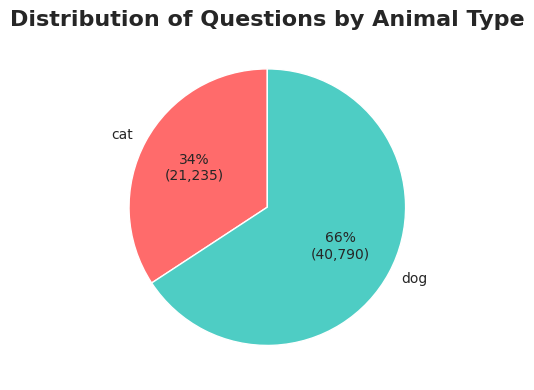

In [10]:
plt.figure(figsize=(6, 4))

def make_autopct(values):
	def my_autopct(pct):
		total = sum(values)
		val = int(round(pct*total/100.0))
		return f'{pct:.0f}%\n({val:,})'
	return my_autopct

plt.pie(animal_counter.values(), labels=animal_counter.keys(), 
		autopct=make_autopct(animal_counter.values()), startangle=90, colors=['#FF6B6B', '#4ECDC4'])
plt.title('Distribution of Questions by Animal Type', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
all_answers = []
answers_per_question = []
expert_answers = []
nonexpert_answers = []
selected_answers = []
multiple_selected_answers_samples = []
questions_with_selected_expert = 0


for item in data:
	question_answers = item['answers']
	answers_per_question.append(len(question_answers))

	selected_answers_cnt = 0
	max_selected_answers_cnt = 0
 
	for answer in question_answers:
		answer_info = {
			'answer_type': answer['answer_type'],
			'selected': answer['selected'],
			'q_id': item['q_id'],
			'animal_type': item['animal_type']
		}
		all_answers.append(answer_info)
		
		if answer['answer_type'] == 'expert':
			expert_answers.append(answer_info)
		else:
			nonexpert_answers.append(answer_info)
		
		if answer['selected']:
			selected_answers.append(answer_info)
			selected_answers_cnt += 1
	
	if selected_answers_cnt > 1:
		multiple_selected_answers_samples.append(item)

questions_with_selected_expert = 0
questions_with_selected_expert_and_nonexpert = 0
for item in data:
    has_selected_expert = False
    has_selected_nonexpert = False
    
    for answer in item['answers']:
        if answer['answer_type'] == 'expert' and answer['selected']:
            has_selected_expert = True
        if answer['answer_type'] != 'expert' and answer['selected']:
            has_selected_nonexpert = True
    if has_selected_expert:
        questions_with_selected_expert += 1
        if has_selected_nonexpert:
            questions_with_selected_expert_and_nonexpert += 1
  

print(f"Ï†ÑÏ≤¥ ÎãµÎ≥Ä: {len(all_answers):,}Í∞ú")
print(f"Expert ÎãµÎ≥Ä: {len(expert_answers):,}Í∞ú ({len(expert_answers)/len(all_answers)*100:.2f}%)")
print(f"Nonexpert ÎãµÎ≥Ä: {len(nonexpert_answers):,}Í∞ú ({len(nonexpert_answers)/len(all_answers)*100:.2f}%)")
print(f"Ï±ÑÌÉùÎêú ÎãµÎ≥Ä: {len(selected_answers):,}Í∞ú ({len(selected_answers)/len(all_answers)*100:.2f}%)")
print(f"Ïó¨Îü¨ Í∞úÏùò Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ Ï°¥Ïû¨ÌïòÎäî ÏÉòÌîå: {len(multiple_selected_answers_samples):,}Í∞ú")
print(f"Ï±ÑÌÉùÎêú Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏßàÎ¨∏: {questions_with_selected_expert}Í∞ú")
print(f"Ï±ÑÌÉùÎêú Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥ÄÍ≥º ÏùºÎ∞òÏù∏ ÎãµÎ≥ÄÏù¥ Î™®Îëê Ï°¥Ïû¨ÌïòÎäî ÏßàÎ¨∏: {questions_with_selected_expert_and_nonexpert:,}Í∞ú")

max_selected_cnt = 0
max_selected_sample = None

for sample in multiple_selected_answers_samples:
    selected_cnt = sum([ans['selected'] for ans in sample['answers']])
    if selected_cnt > max_selected_cnt:
        max_selected_cnt = selected_cnt
        max_selected_sample = sample

print(f"Ïó¨Îü¨ Ï±ÑÌÉù ÎãµÎ≥Ä Ï§ë ÏµúÎåÄ Ï±ÑÌÉù Í∞úÏàò: {max_selected_cnt}")

Ï†ÑÏ≤¥ ÎãµÎ≥Ä: 86,961Í∞ú
Expert ÎãµÎ≥Ä: 14,846Í∞ú (17.07%)
Nonexpert ÎãµÎ≥Ä: 72,115Í∞ú (82.93%)
Ï±ÑÌÉùÎêú ÎãµÎ≥Ä: 64,129Í∞ú (73.74%)
Ïó¨Îü¨ Í∞úÏùò Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ Ï°¥Ïû¨ÌïòÎäî ÏÉòÌîå: 2,235Í∞ú
Ï±ÑÌÉùÎêú Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏßàÎ¨∏: 14700Í∞ú
Ï±ÑÌÉùÎêú Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥ÄÍ≥º ÏùºÎ∞òÏù∏ ÎãµÎ≥ÄÏù¥ Î™®Îëê Ï°¥Ïû¨ÌïòÎäî ÏßàÎ¨∏: 1,923Í∞ú
Ïó¨Îü¨ Ï±ÑÌÉù ÎãµÎ≥Ä Ï§ë ÏµúÎåÄ Ï±ÑÌÉù Í∞úÏàò: 5


In [2]:
"""ÎØ∏Ï±ÑÌÉù Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥Ä"""
import json
raw_data_path = "/home/work/factchecking/PetQA/data/interim/unique_data.json"
with open(raw_data_path, 'r', encoding='utf-8') as f:
	data = json.load(f)

unselected_expert_answers = []
for item in data:
    q_id = item['q_id']
    title = item['title']
    content = item['content']
    answers = item['answers']
    animal_type = item['animal_type']
    link = item['link']
    
    for answer in answers:
        if answer['answer_type'] == 'expert' and not answer['selected']:
            unselected_expert_answer = {
                'q_id': q_id,
                'title': title,
                'content': content,
                'answers': answers,
                'question_date': item['question_date'],
                'animal_type': animal_type,
                'link': link
            }
            unselected_expert_answers.append(unselected_expert_answer)

with open('unselected_expert_answers.json', 'w', encoding='utf-8') as f:
    json.dump(unselected_expert_answers, f, ensure_ascii=False, indent=2)
print(f"Ï±ÑÌÉùÎêòÏßÄ ÏïäÏùÄ Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥Ä: {len(unselected_expert_answers)}Í∞ú")

Ï±ÑÌÉùÎêòÏßÄ ÏïäÏùÄ Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥Ä: 145Í∞ú


In [6]:
ids = []
for item in data:
	question_answers = item['answers']
	expert_count = 0
	
	for answer in question_answers:
		if answer['answer_type'] == 'expert':
			expert_count += 1
	
	if expert_count >= 2:
		ids.append(item['q_id'])

if ids:
	print(f"Expert ÎãµÎ≥ÄÏù¥ 2Í∞ú Ïù¥ÏÉÅÏù∏ ÏÉòÌîå: {ids}")
else:
	print("Expert ÎãµÎ≥ÄÏù¥ 2Í∞ú Ïù¥ÏÉÅÏù∏ ÏÉòÌîåÏù¥ ÏóÜÏäµÎãàÎã§.")

Expert ÎãµÎ≥ÄÏù¥ 2Í∞ú Ïù¥ÏÉÅÏù∏ ÏßàÎ¨∏Îì§: [18178]


In [10]:
import numpy as np
from collections import Counter

total_answers = len(all_answers)
print(f"Ï¥ù ÎãµÎ≥Ä Í∞úÏàò: {total_answers:,}")

# ÏßàÎ¨∏Îãπ ÎãµÎ≥Ä Í∞úÏàò ÌÜµÍ≥Ñ
min_answers = min(answers_per_question)
max_answers = max(answers_per_question)
avg_answers = np.mean(answers_per_question)
median_answers = np.median(answers_per_question)
std_answers = np.std(answers_per_question)

print(f"\nÏßàÎ¨∏Îãπ ÎãµÎ≥Ä Í∞úÏàò ÌÜµÍ≥Ñ:")
print(f"  ÏµúÏÜå: {min_answers}Í∞ú")
print(f"  ÏµúÎåÄ: {max_answers}Í∞ú")
print(f"  ÌèâÍ∑†: {avg_answers:.2f}Í∞ú")

# ÎãµÎ≥Ä Í∞úÏàò Î∂ÑÌè¨
answer_count_distribution = Counter(answers_per_question)
print(f"\nÎãµÎ≥Ä Í∞úÏàòÎ≥Ñ ÏßàÎ¨∏ Î∂ÑÌè¨:")
for count in sorted(answer_count_distribution.keys()):
	frequency = answer_count_distribution[count]
	percentage = (frequency / len(data)) * 100
	print(f"  {count}Í∞ú ÎãµÎ≥Ä: {frequency:,}Í∞ú ÏßàÎ¨∏ ({percentage:.2f}%)")

Ï¥ù ÎãµÎ≥Ä Í∞úÏàò: 86,961

ÏßàÎ¨∏Îãπ ÎãµÎ≥Ä Í∞úÏàò ÌÜµÍ≥Ñ:
  ÏµúÏÜå: 1Í∞ú
  ÏµúÎåÄ: 5Í∞ú
  ÌèâÍ∑†: 1.41Í∞ú

ÎãµÎ≥Ä Í∞úÏàòÎ≥Ñ ÏßàÎ¨∏ Î∂ÑÌè¨:
  1Í∞ú ÎãµÎ≥Ä: 43,197Í∞ú ÏßàÎ¨∏ (69.87%)
  2Í∞ú ÎãµÎ≥Ä: 13,718Í∞ú ÏßàÎ¨∏ (22.19%)
  3Í∞ú ÎãµÎ≥Ä: 3,666Í∞ú ÏßàÎ¨∏ (5.93%)
  4Í∞ú ÎãµÎ≥Ä: 890Í∞ú ÏßàÎ¨∏ (1.44%)
  5Í∞ú ÎãµÎ≥Ä: 354Í∞ú ÏßàÎ¨∏ (0.57%)


In [37]:
"""Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ 3Í∞ú Ïù¥ÏÉÅÏù∏ ÏÉòÌîå"""
selected_3_or_more = []
for item in data:
    question_answers = item['answers']
    selected_count = 0

    for answer in question_answers:
        if answer['selected']:
            selected_count += 1

    if selected_count >= 3:
        selected_3_or_more.append(item)

print(f"Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ 3Í∞ú Ïù¥ÏÉÅÏù∏ ÏÉòÌîå: {len(selected_3_or_more)}")
output_path = "selected_3_or_more.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(selected_3_or_more, f, ensure_ascii=False, indent=2)

Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ 3Í∞ú Ïù¥ÏÉÅÏù∏ ÏÉòÌîå: 2235


In [ ]:
"""ÎãµÎ≥ÄÏù¥ 5Í∞úÏù∏ ÏÉòÌîå ÌôïÏù∏"""
import json
raw_data_path = "/home/work/factchecking/PetQA/data/interim/unique_data.json"
with open(raw_data_path, 'r', encoding='utf-8') as f:
	data = json.load(f)
 
answer_5 = []
for item in data:
    answers = item['answers']
    


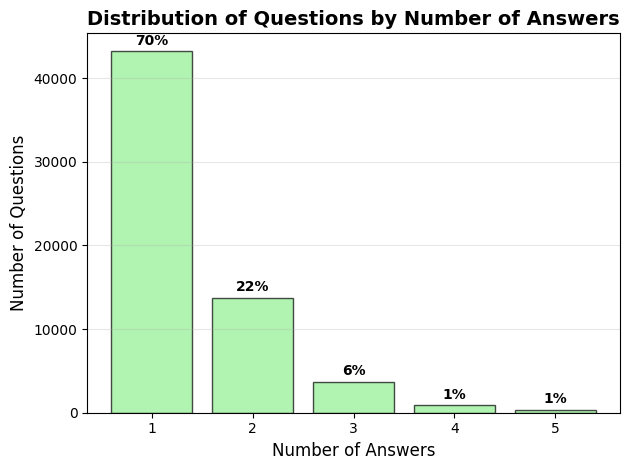

In [12]:
import matplotlib.pyplot as plt

counts = list(answer_count_distribution.keys())
frequencies = [answer_count_distribution[c] for c in counts]

plt.bar(counts, frequencies, color='lightgreen', alpha=0.7, edgecolor='black')
plt.title('Distribution of Questions by Number of Answers', fontsize=14, fontweight='bold')
plt.xlabel('Number of Answers', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.xticks(counts)
plt.grid(True, alpha=0.3, axis='y')

total = sum(frequencies)
# ÎßâÎåÄ ÏúÑÏóê ÏàòÏπò ÌëúÏãú
for i, freq in enumerate(frequencies):
	percent = freq / total * 100
	plt.text(counts[i], freq + max(frequencies)*0.01,
			 f'{percent:.0f}%',  # ÎπàÎèÑÏôÄ ÎπÑÏú® Î™®Îëê ÌëúÏãú
			ha='center', va='bottom', fontweight='bold'
	)

plt.tight_layout()
plt.show()

In [13]:
expert_count = len(expert_answers)
nonexpert_count = len(nonexpert_answers)

print(f"ÎãµÎ≥Ä Ïú†ÌòïÎ≥Ñ ÌÜµÍ≥Ñ:")
print(f"  Expert ÎãµÎ≥Ä: {expert_count:,}Í∞ú ({expert_count/total_answers*100:.2f}%)")
print(f"  Nonexpert ÎãµÎ≥Ä: {nonexpert_count:,}Í∞ú ({nonexpert_count/total_answers*100:.2f}%)")

# Ï±ÑÌÉù ÎπÑÏú® Î∂ÑÏÑù
expert_selected = sum(1 for ans in expert_answers if ans['selected'])
nonexpert_selected = sum(1 for ans in nonexpert_answers if ans['selected'])

expert_selection_rate = (expert_selected / expert_count * 100) if expert_count > 0 else 0
nonexpert_selection_rate = (nonexpert_selected / nonexpert_count * 100) if nonexpert_count > 0 else 0

print(f"\nÏ±ÑÌÉù ÎπÑÏú® Î∂ÑÏÑù:")
print(f"  Expert ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: {expert_selected:,}/{expert_count:,} ({expert_selection_rate:.2f}%)")
print(f"  Nonexpert ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: {nonexpert_selected:,}/{nonexpert_count:,} ({nonexpert_selection_rate:.2f}%)")
print(f"  Ï†ÑÏ≤¥ Ï±ÑÌÉùÎêú ÎãµÎ≥Ä Ïàò: {len(selected_answers):,}")

ÎãµÎ≥Ä Ïú†ÌòïÎ≥Ñ ÌÜµÍ≥Ñ:
  Expert ÎãµÎ≥Ä: 14,846Í∞ú (17.07%)
  Nonexpert ÎãµÎ≥Ä: 72,115Í∞ú (82.93%)

Ï±ÑÌÉù ÎπÑÏú® Î∂ÑÏÑù:
  Expert ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: 14,701/14,846 (99.02%)
  Nonexpert ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: 49,428/72,115 (68.54%)
  Ï†ÑÏ≤¥ Ï±ÑÌÉùÎêú ÎãµÎ≥Ä Ïàò: 64,129


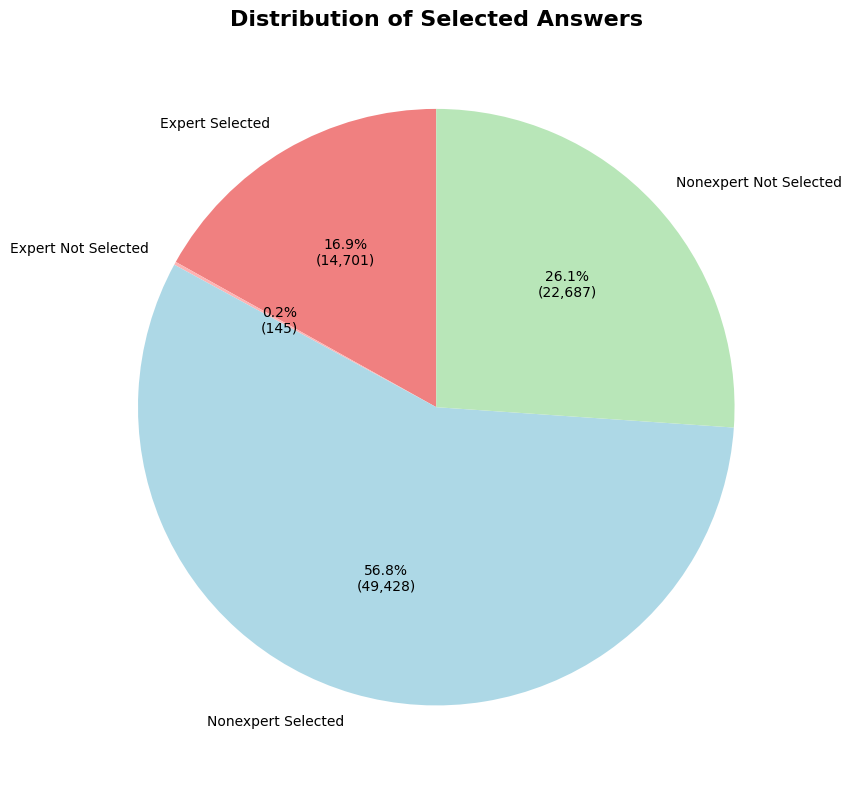

In [14]:
# 4Í∞ú ÏÑπÏÖòÏúºÎ°ú Î∂ÑÌï†Îêú ÏÉÅÏÑ∏ ÌååÏù¥Ï∞®Ìä∏
plt.figure(figsize=(12, 8))

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
labels_detailed = ['Expert Selected', 'Expert Not Selected', 'Nonexpert Selected', 'Nonexpert Not Selected']
sizes_detailed = [expert_selected, expert_count - expert_selected, 
				  nonexpert_selected, nonexpert_count - nonexpert_selected]
colors_detailed = ['lightcoral', '#FFB3B3', 'lightblue', '#B8E6B8']

def make_autopct(values):
	def my_autopct(pct):
		total = sum(values)
		val = int(round(pct*total/100.0))
		return f'{pct:.1f}%\n({val:,})'
	return my_autopct

# ÌååÏù¥Ï∞®Ìä∏ ÏÉùÏÑ±
wedges, texts, autotexts = plt.pie(sizes_detailed, labels=labels_detailed, colors=colors_detailed,
								   autopct=make_autopct(sizes_detailed), startangle=90, textprops={'fontsize': 10})

plt.title('Distribution of Selected Answers', fontsize=16, fontweight='bold')


plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
# ÏßàÎ¨∏Î≥Ñ Ï¢ÖÌï© Ï†ïÎ≥¥ ÏÉùÏÑ±
question_data = []
for item in data:
	question_info = {
		'q_id': item['q_id'],
		'animal_type': item['animal_type'],
		'num_answers': len(item['answers']),
		'has_expert': any(ans['answer_type'] == 'expert' for ans in item['answers']),
		'has_selected': any(ans['selected'] for ans in item['answers']),
		'num_selected': sum(ans['selected'] for ans in item['answers']),
		'num_expert': sum(1 for ans in item['answers'] if ans['answer_type'] == 'expert'),
		'num_nonexpert': sum(1 for ans in item['answers'] if ans['answer_type'] == 'nonexpert')
	}
	question_data.append(question_info)

questions_df = pd.DataFrame(question_data)
answers_df = pd.DataFrame(all_answers)

print(f"Í∏∞Î≥∏ ÌÜµÍ≥Ñ:")
print(f"Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏÉòÌîåÏùò Ïàò: {questions_df['has_expert'].sum():,}Í∞ú ({questions_df['has_expert'].mean()*100:.2f}%)")
print(f"Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏÉòÌîåÏùò Ïàò: {questions_df['has_selected'].sum():,}Í∞ú ({questions_df['has_selected'].mean()*100:.2f}%)")


Í∏∞Î≥∏ ÌÜµÍ≥Ñ:
Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏÉòÌîåÏùò Ïàò: 14,845Í∞ú (24.01%)
Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏÉòÌîåÏùò Ïàò: 61,825Í∞ú (100.00%)


In [163]:
for animal in questions_df['animal_type'].unique():
	print(f"\n{animal.upper()} Î∂ÑÏÑù:")
	print("-" * 30)
	
	animal_questions = questions_df[questions_df['animal_type'] == animal]
	animal_answers = answers_df[answers_df['animal_type'] == animal]
	
	# Í∏∞Î≥∏ ÌÜµÍ≥Ñ
	print(f"ÏßàÎ¨∏ Ïàò: {len(animal_questions):,}")
	print(f"Ï¥ù ÎãµÎ≥Ä Ïàò: {len(animal_answers):,}")
	print(f"ÌèâÍ∑† ÎãµÎ≥Ä Ïàò: {animal_questions['num_answers'].mean():.2f}")
	
	# ÎãµÎ≥Ä Ïú†Ìòï Î∂ÑÏÑù
	expert_count_animal = len(animal_answers[animal_answers['answer_type'] == 'expert'])
	expert_ratio = expert_count_animal / len(animal_answers) * 100 if len(animal_answers) > 0 else 0
	print(f"Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥Ä ÎπÑÏú®: {expert_ratio:.2f}% ({expert_count_animal:,}/{len(animal_answers):,})")
	
	# # Ï±ÑÌÉùÎ•† Î∂ÑÏÑù
	# selection_ratio = animal_answers['selected'].mean() * 100
	# selected_count = animal_answers['selected'].sum()
	# print(f"ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: {selection_ratio:.2f}% ({selected_count:,}/{len(animal_answers):,})")


CAT Î∂ÑÏÑù:
------------------------------
ÏßàÎ¨∏ Ïàò: 21,235
Ï¥ù ÎãµÎ≥Ä Ïàò: 29,562
ÌèâÍ∑† ÎãµÎ≥Ä Ïàò: 1.39
Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥Ä ÎπÑÏú®: 8.28% (2,448/29,562)
ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: 73.15% (21,626/29,562)

DOG Î∂ÑÏÑù:
------------------------------
ÏßàÎ¨∏ Ïàò: 40,790
Ï¥ù ÎãµÎ≥Ä Ïàò: 57,869
ÌèâÍ∑† ÎãµÎ≥Ä Ïàò: 1.42
Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥Ä ÎπÑÏú®: 21.76% (12,592/57,869)
ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: 73.94% (42,790/57,869)


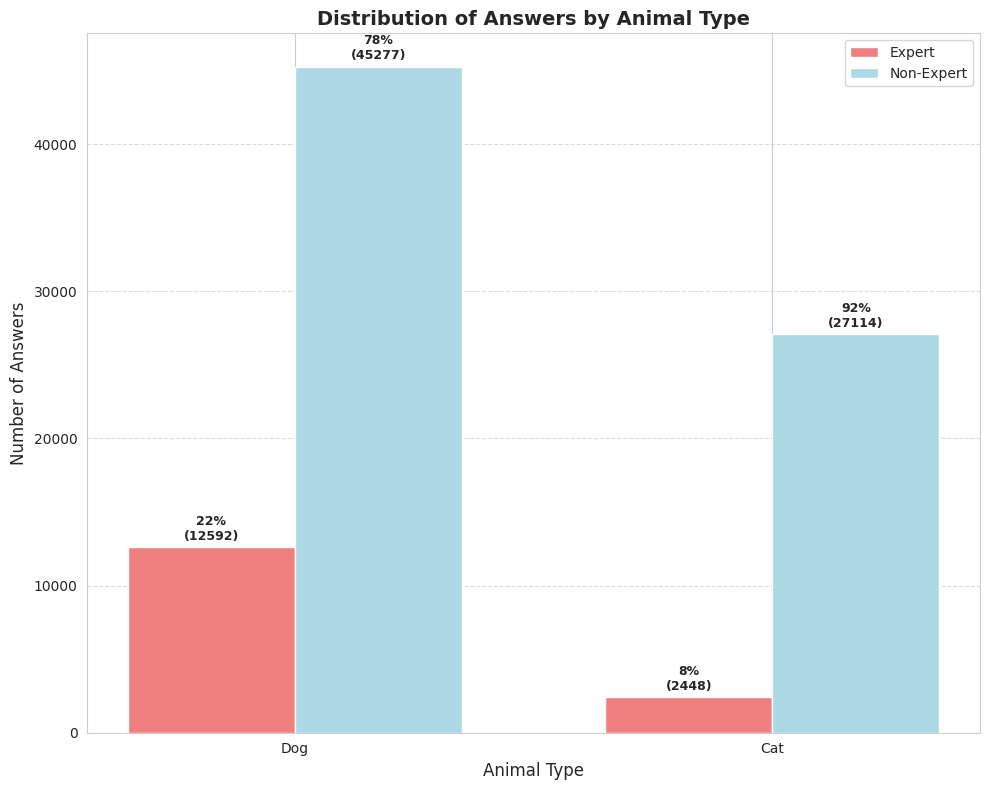

In [177]:
# DogÏôÄ CatÏùò Ï†ÑÎ¨∏Í∞Ä/ÏùºÎ∞òÏù∏ ÎãµÎ≥Ä Í∞úÏàò Í≥ÑÏÇ∞
dog_expert_count = answers_df[(answers_df['animal_type'] == 'dog') & (answers_df['answer_type'] == 'expert')].shape[0]
dog_non_expert_count = answers_df[(answers_df['animal_type'] == 'dog') & (answers_df['answer_type'] == 'nonexpert')].shape[0]
cat_expert_count = answers_df[(answers_df['animal_type'] == 'cat') & (answers_df['answer_type'] == 'expert')].shape[0]
cat_non_expert_count = answers_df[(answers_df['animal_type'] == 'cat') & (answers_df['answer_type'] == 'nonexpert')].shape[0]

animals = ['Dog', 'Cat']
expert_counts = [dog_expert_count, cat_expert_count]
non_expert_counts = [dog_non_expert_count, cat_non_expert_count]

x = np.arange(len(animals))
width = 0.35  # ÎßâÎåÄÏùò ÎÑàÎπÑ

fig, ax = plt.subplots(figsize=(10, 8))

rects1 = ax.bar(x - width/2, expert_counts, width, label='Expert', color='lightcoral')
rects2 = ax.bar(x + width/2, non_expert_counts, width, label='Non-Expert', color='lightblue')

ax.set_xlabel('Animal Type', fontsize=12)
ax.set_ylabel('Number of Answers', fontsize=12)
ax.set_title('Distribution of Answers by Animal Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(animals, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Í∞Å ÎßâÎåÄ ÏúÑÏóê ÏàòÏπò ÌëúÏãú Ìï®Ïàò
total_counts = [dog_expert_count + dog_non_expert_count, cat_expert_count + cat_non_expert_count]

def autolabel_percent(rects, counts, total):
	for rect, count, tot in zip(rects, counts, total):
		height = rect.get_height()
		percent = height / tot * 100 if tot > 0 else 0
		ax.annotate(f'{percent:.0f}%\n({int(height)})',
					xy=(rect.get_x() + rect.get_width() / 2, height),
					xytext=(0, 3),  # 3 points vertical offset
					textcoords="offset points",
					ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel_percent(rects1, expert_counts, total_counts)
autolabel_percent(rects2, non_expert_counts, total_counts)

fig.tight_layout()
plt.show()

In [83]:
print("=" * 80)
print("üìä PetQA Îç∞Ïù¥ÌÑ∞ÏÖã EDA ÏµúÏ¢Ö ÏöîÏïΩ Î¶¨Ìè¨Ìä∏")
print("=" * 80)

print(f"\nüîç Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏöî:")
print(f"  ‚Ä¢ Ï¥ù ÏßàÎ¨∏ Ïàò: {total_questions:,}Í∞ú")
print(f"  ‚Ä¢ Ï¥ù ÎãµÎ≥Ä Ïàò: {total_answers:,}Í∞ú")
print(f"  ‚Ä¢ ÌèâÍ∑† ÏßàÎ¨∏Îãπ ÎãµÎ≥Ä Ïàò: {avg_answers:.2f}Í∞ú")

print(f"\nüêïüê± Animal Type Î∂ÑÌè¨:")
for animal, count in animal_counter.items():
	percentage = (count / total_questions) * 100
	print(f"  ‚Ä¢ {animal}: {count:,}Í∞ú ({percentage:.1f}%)")

print(f"\nüë®‚Äç‚öïÔ∏è ÎãµÎ≥ÄÏûê Ïú†Ìòï Î∂ÑÏÑù:")
print(f"  ‚Ä¢ Expert ÎãµÎ≥Ä: {expert_count:,}Í∞ú ({expert_count/total_answers*100:.1f}%)")
print(f"  ‚Ä¢ Nonexpert ÎãµÎ≥Ä: {nonexpert_count:,}Í∞ú ({nonexpert_count/total_answers*100:.1f}%)")

print(f"\n‚úÖ Ï±ÑÌÉùÎ•† Î∂ÑÏÑù:")
print(f"  ‚Ä¢ Expert ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: {expert_selection_rate:.1f}%")
print(f"  ‚Ä¢ Nonexpert ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: {nonexpert_selection_rate:.1f}%")
print(f"  ‚Ä¢ Ï†ÑÏ≤¥ Ï±ÑÌÉùÎêú ÎãµÎ≥Ä: {len(selected_answers):,}Í∞ú")

print(f"\nüìà ÏßàÎ¨∏Î≥Ñ ÌÜµÍ≥Ñ:")
print(f"  ‚Ä¢ Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏßàÎ¨∏: {questions_df['has_expert'].sum():,}Í∞ú ({questions_df['has_expert'].mean()*100:.1f}%)")
print(f"  ‚Ä¢ Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏßàÎ¨∏: {questions_df['has_selected'].sum():,}Í∞ú ({questions_df['has_selected'].mean()*100:.1f}%)")

print(f"\n" + "=" * 80)

üìä PetQA Îç∞Ïù¥ÌÑ∞ÏÖã EDA ÏµúÏ¢Ö ÏöîÏïΩ Î¶¨Ìè¨Ìä∏

üîç Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏöî:
  ‚Ä¢ Ï¥ù ÏßàÎ¨∏ Ïàò: 62,025Í∞ú
  ‚Ä¢ Ï¥ù ÎãµÎ≥Ä Ïàò: 87,431Í∞ú
  ‚Ä¢ ÌèâÍ∑† ÏßàÎ¨∏Îãπ ÎãµÎ≥Ä Ïàò: 1.41Í∞ú

üêïüê± Animal Type Î∂ÑÌè¨:
  ‚Ä¢ cat: 21,235Í∞ú (34.2%)
  ‚Ä¢ dog: 40,790Í∞ú (65.8%)

üë®‚Äç‚öïÔ∏è ÎãµÎ≥ÄÏûê Ïú†Ìòï Î∂ÑÏÑù:
  ‚Ä¢ Expert ÎãµÎ≥Ä: 15,040Í∞ú (17.2%)
  ‚Ä¢ Nonexpert ÎãµÎ≥Ä: 72,391Í∞ú (82.8%)

‚úÖ Ï±ÑÌÉùÎ•† Î∂ÑÏÑù:
  ‚Ä¢ Expert ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: 98.6%
  ‚Ä¢ Nonexpert ÎãµÎ≥Ä Ï±ÑÌÉùÎ•†: 68.5%
  ‚Ä¢ Ï†ÑÏ≤¥ Ï±ÑÌÉùÎêú ÎãµÎ≥Ä: 64,416Í∞ú

üìà ÏßàÎ¨∏Î≥Ñ ÌÜµÍ≥Ñ:
  ‚Ä¢ Ï†ÑÎ¨∏Í∞Ä ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏßàÎ¨∏: 15,038Í∞ú (24.2%)
  ‚Ä¢ Ï±ÑÌÉùÎêú ÎãµÎ≥ÄÏù¥ ÏûàÎäî ÏßàÎ¨∏: 62,025Í∞ú (100.0%)



# ÌÜ†ÌÅ∞ Í≥ÑÏÇ∞

In [18]:
import tiktoken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import anthropic
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [ ]:
df = pd.read_json("/home/work/factchecking/PetQA/data/interim/petqa.json")

In [178]:
import math
models = {
	'gpt-4o-mini': {"input_token": 0.15, "output_token": 0.60, "avg_output_token": 127},
	'claude-3-haiku': {"input_token": 0.25, "output_token": 1.25, "avg_output_token": 238},
	'gemini-2.0-flash': {"input_token": 0.1, "output_token": 0.4, "avg_output_token": 122},
}

avg_input_token = {
	"0": [265, 417, 231],
	"1": [567, 916, 510],
	"3": [1181, 1933, 1074],
	"6": [2106, 3464, 1925],
}

total_cost = 0

print("Ï†ÑÏ≤òÎ¶¨ (gpt-4o-mini)")
filtering_size = 62025
cost = models["gpt-4o-mini"]["input_token"] * 584 + models["gpt-4o-mini"]["output_token"] * 1
cost = math.ceil((cost * filtering_size) / 1000000)
total_cost += cost
print(f"ÌïÑÌÑ∞ÎßÅ ÎπÑÏö©: {cost} USD")

cleaning_size = 62025
cost = models["gpt-4o-mini"]["input_token"] * 760 + models["gpt-4o-mini"]["output_token"] * 278
cost = math.ceil((cost * cleaning_size) / 1000000)
total_cost += cost
print(f"ÌÅ¥Î¶¨Îãù ÎπÑÏö©: {cost} USD")
print("---"*10)

print("ÎãµÎ≥Ä ÏÉùÏÑ± ÎπÑÏö©")
test_size = 2000  # 500 * 4
for i, (model_name, price) in enumerate(models.items()):
	for shot, tokens in avg_input_token.items():
		# ÏûÖÎ†• ÌòïÏãùÏóê Îî∞Î•∏ ÎπÑÏö© Í≥†Î†§
		cost = 2 * (price["input_token"] * tokens[i] + price["output_token"] * price["avg_output_token"])
		cost = math.ceil((cost * test_size) / 1000000)
		total_cost += cost
		print(f"{model_name}-{shot}: {cost} USD")
	print("---"*10)

print(f"Ï¥ù ÎπÑÏö©: {total_cost} USD")

Ï†ÑÏ≤òÎ¶¨ (gpt-4o-mini)
ÌïÑÌÑ∞ÎßÅ ÎπÑÏö©: 6 USD
ÌÅ¥Î¶¨Îãù ÎπÑÏö©: 18 USD
------------------------------
ÎãµÎ≥Ä ÏÉùÏÑ± ÎπÑÏö©
gpt-4o-mini-0: 1 USD
gpt-4o-mini-1: 1 USD
gpt-4o-mini-3: 2 USD
gpt-4o-mini-6: 2 USD
------------------------------
claude-3-haiku-0: 2 USD
claude-3-haiku-1: 3 USD
claude-3-haiku-3: 4 USD
claude-3-haiku-6: 5 USD
------------------------------
gemini-2.0-flash-0: 1 USD
gemini-2.0-flash-1: 1 USD
gemini-2.0-flash-3: 1 USD
gemini-2.0-flash-6: 1 USD
------------------------------
Ï¥ù ÎπÑÏö©: 48 USD
